# SPERIMENTAZIONE DI UNA APPLICAZIONE DI MACHINE LEARNING SUI DATI COMUNALI

Questo notebook documenta una sperimentazione esplorativa su un dataset open data del Comune di Bari relativo agli incidenti stradali (anno 2023). L’obiettivo è verificare in che misura dati amministrativi aperti possano supportare analisi a supporto decisionale, sia in chiave **predittiva** sia in chiave **esplorativa/spaziale**.

# Obiettivi
1. **Classificazione**: stimare la probabilità che un incidente comporti *lesioni* a partire da un insieme di variabili descrittive.
2. **Analisi spaziale**: individuare eventuali **hotspot** tramite clustering geografico (DBSCAN), distinguendo aree con maggiore incidenza di eventi con lesioni.

## Modelli e strumenti
- Classificazione supervisionata: **Regressione logistica**, **MLPClassifier** (rete neurale feed-forward).
- Clustering spaziale: **DBSCAN**.
- Metriche: accuracy, precision, recall, F1-score; analisi descrittiva dei cluster.


# Step 1 — Import librerie e caricamento datasetin questo primo blocco:
In questa sezione:
- importiamo le librerie necessarie;
- carichiamo il dataset direttamente da sorgente remota (CSV), così da rendere la sperimentazione riproducibile.

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

url = "https://opendata.comune.bari.it/dataset/6738d454-744f-456a-a1d8-858d0adeb177/resource/eeca93bd-96b4-4da6-bdf7-0531f6c8cfa8/download/elenco-incidenti-periodo-2023.csv"

df = pd.read_csv(url, delimiter=',')

df

,Data incidente,Latitudine,Longitudine,Centro abitato,Tipo di strada,Caratteristiche della strada,Stato fondo stradale,Tipo pavimentazione,Condizioni meteo,Condizioni traffico,Danni a cose,Incidente con lesioni,Inviata ore,Sul posto ore
0,01/01/2023,41.081200,16.898610,si,Provinciale entro l'abitato,Incrocio,Asciutto,Asfaltata,Sereno,Scarso,no,no,04:25,04:30
1,01/01/2023,41.124040,16.875830,si,Strada Urbana,Intersezione stradale segnalata,Asciutto,Asfaltata,Sereno,Intenso,no,no,12:04,12:12
2,01/01/2023,41.092230,16.870050,si,Strada Urbana,Incrocio,Bagnato (umidita' in atto),Asfaltata,Sereno,Normale,no,si,19:15,19:25
3,02/01/2023,41.120550,16.855240,si,Strada Urbana,Incrocio,Asciutto,Asfaltata,Sereno,Scarso,no,no,01:00,01:10
4,02/01/2023,41.112580,16.873940,si,Strada Urbana,Rettilineo,Asciutto,Asfaltata,Sereno,Normale,no,no,09:45,09:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,31/12/2023,41.093290,16.858600,si,Strada Urbana,Rettilineo,Asciutto,Asfaltata,Sereno,Scarso,no,no,10:55,11:00
3411,31/12/2023,41.129370,16.833940,si,Strada Urbana,Intersezione semaforizzata,Asciutto,Asfaltata,Sereno,Scarso,no,si,12:45,13:00
3412,31/12/2023,41.113374,16.872278,si,Strada Urbana,Incrocio,Asciutto,Asfaltata,Sereno,Scarso,no,no,15:10,15:15
3413,31/12/2023,41.128240,16.859470,si,Strada Urbana,Intersezione semaforizzata,Asciutto,Asfaltata,Sereno,Normale,no,no,15:55,16:10


# Step 2 — Preprocessing e selezione variabili

Per semplificare l’analisi:
- uniformiamo i nomi delle colonne (minuscole, senza spazi);
- selezioniamo un sottoinsieme di variabili potenzialmente informative per la fase di classificazione;
- verifichiamo la presenza di valori mancanti e la loro incidenza.

## Variabili candidate (feature)
- centro_abitato
- tipo_di_strada
- caratteristiche_della_strada
- stato_fondo_stradale
- tipo_pavimentazione
- condizioni_meteo
- condizioni_traffico
- ora
- danni_a_cose



In [38]:
# Rinominiamo colonne per semplificare il codice
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]


df.isnull().sum()



data_incidente                  0
latitudine                      2
longitudine                     2
centro_abitato                  0
tipo_di_strada                  0
caratteristiche_della_strada    0
stato_fondo_stradale            0
tipo_pavimentazione             0
condizioni_meteo                0
condizioni_traffico             1
danni_a_cose                    0
incidente_con_lesioni           1
inviata_ore                     0
sul_posto_ore                   0
dtype: int64

## Preparazione dei dati

- Poiché l’incidenza di valori mancanti risulta contenuta, adottiamo una strategia semplice di rimozione delle righe incomplete.
- Convertiamo la variabile target `incidente_con_lesioni` in una variabile binaria (0/1), da utilizzare nei modelli di classificazione.


In [39]:
# Creazione della variabile target: 1 se ci sono lesioni, 0 altrimenti
df['lesioni'] = df['incidente_con_lesioni'].str.lower().map({'si': 1, 'no': 0})

# estraiamo l'ora dall'invio della segnalazione
df['ora'] = pd.to_datetime(df['inviata_ore'], format='%H:%M', errors='coerce').dt.hour

# Selezioniamo le variabili indipendenti per il modello
categorical_features = [
    'centro_abitato', 'tipo_di_strada', 'caratteristiche_della_strada',
    'stato_fondo_stradale', 'tipo_pavimentazione',
    'condizioni_meteo', 'condizioni_traffico', 'danni_a_cose'
]

numeric_features = ['ora']

# Rimuoviamo le righe con valori mancanti nelle feature selezionate
df_model = df[categorical_features+numeric_features + ['lesioni']].dropna() 

X_senza_onehot= df_model
y = df_model['lesioni']

encoder = OneHotEncoder(sparse_output=False)
X_cat_encoded = encoder.fit_transform(X_senza_onehot[categorical_features])

encoded_col_names = encoder.get_feature_names_out(categorical_features)

# Creazione DataFrame
X = pd.DataFrame(X_cat_encoded, columns=encoded_col_names)

# 7. Aggiunta colonna 'ora'
X[numeric_features] = X_senza_onehot[numeric_features].reset_index(drop=True)

# Verifichiamo dimensioni dataset e distribuzione target
print("Shape X:", X.shape)
print("Distribuzione target:\n", y.value_counts())

X

Shape X: (3413, 52)
Distribuzione target:
 lesioni
0.0    1933
1.0    1480
Name: count, dtype: int64


,centro_abitato_no,centro_abitato_si,tipo_di_strada_Altra strada,tipo_di_strada_Comunale extraurbana,tipo_di_strada_Provinciale,tipo_di_strada_Provinciale entro l'abitato,tipo_di_strada_Statale,tipo_di_strada_Statale entro l'abitato,tipo_di_strada_Strada Urbana,caratteristiche_della_strada_Cavalcavia,...,condizioni_meteo_Pioggia in atto,condizioni_meteo_Sereno,condizioni_meteo_Sole radente,condizioni_meteo_Vento forte,condizioni_traffico_Intenso,condizioni_traffico_Normale,condizioni_traffico_Scarso,danni_a_cose_no,danni_a_cose_si,ora
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,12
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,19
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,10
3409,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,12
3410,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,15
3411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,15


# Step 3a — Regressione logistica: addestramento e valutazione

Applichiamo una regressione logistica per classificare gli incidenti in due classi (*con lesioni* / *senza lesioni*) a partire dalle variabili selezionate.

Il modello è scelto per:
- semplicità;
- interpretabilità (baseline utile per confronti successivi).

Dopo la suddivisione train/test, valutiamo le prestazioni con accuracy, precision, recall e F1-score.

In [40]:


# Suddividiamo in training set e test set (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y
)

# Creiamo il modello ed effettuiamo predizione 
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# stampiamo la matrice di confusione e metriche di classificazione
print("Matrice di confusione:")
print(confusion_matrix(y_test, y_pred))

print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))

Matrice di confusione:
[[552  28]
 [416  28]]

Report di classificazione:
              precision    recall  f1-score   support

         0.0       0.57      0.95      0.71       580
         1.0       0.50      0.06      0.11       444

    accuracy                           0.57      1024
   macro avg       0.54      0.51      0.41      1024
weighted avg       0.54      0.57      0.45      1024



## Step 3b — MLPClassifier: addestramento e valutazione

In questo esperimento utilizziamo una rete neurale feed-forward (MLPClassifier) con un singolo hidden layer, con l’obiettivo di catturare eventuali relazioni non lineari tra variabili.

Le metriche di valutazione sono le stesse della regressione logistica, così da consentire un confronto diretto.

In [41]:


# Creiamo il modello: 1 hidden layer con 200 neuroni
mlp = MLPClassifier(hidden_layer_sizes=200, max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

# stampamo la matrice di confusione e metriche di classificazione
print("Matrice di confusione (MLP):")
print(confusion_matrix(y_test, y_pred_mlp))


print("\nReport di classificazione (MLP):")
print(classification_report(y_test, y_pred_mlp))

Matrice di confusione (MLP):
[[392 188]
 [294 150]]

Report di classificazione (MLP):
              precision    recall  f1-score   support

         0.0       0.57      0.68      0.62       580
         1.0       0.44      0.34      0.38       444

    accuracy                           0.53      1024
   macro avg       0.51      0.51      0.50      1024
weighted avg       0.52      0.53      0.52      1024



Gli algoritmi di classificazione non si sono rilevati particolarmente efficaci, infatti i modelli addestrati sono stati in grado di predire praticamente solo la classe senza lesioni. Gli score raggiunti sono poco soddisfacenti nonstante i valori della variabile target non risultino particolarmente sbilanciati, come si evince dal plot seguente: 

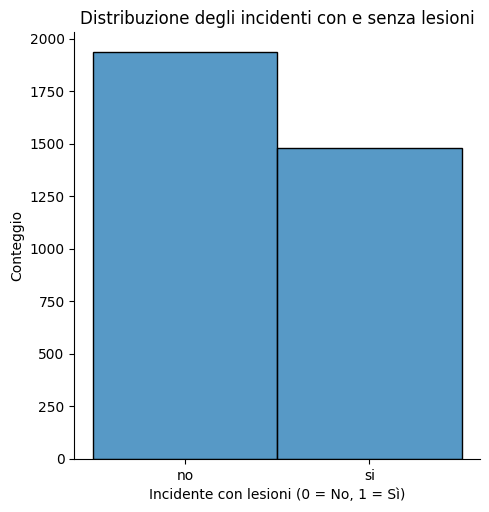

In [42]:
sns.displot(df['incidente_con_lesioni'], bins=2, kde=False)

plt.xlabel("Incidente con lesioni (0 = No, 1 = Sì)")
plt.ylabel("Conteggio")
plt.title("Distribuzione degli incidenti con e senza lesioni")
plt.show()

# Step 4 — Analisi spaziale con DBSCAN

Poiché la classificazione non produce risultati solidi, proseguiamo con un’analisi **esplorativa** orientata allo spazio.

Obiettivo: individuare cluster geografici di incidenti (hotspot) e verificare se alcuni cluster presentano una quota più alta di incidenti con lesioni.

Prima del clustering:
- rimuoviamo outlier geografici per rendere la visualizzazione e l’identificazione dei cluster più robuste.

In [43]:
# Rimuoviamo righe con valori nulli e outlier
df_geo = df[['latitudine', 'longitudine', 'lesioni']].dropna()

# manteniamo solo i valori tra il 1° e 99° percentile
lat_q_low, lat_q_high = df_geo['latitudine'].quantile([0.01, 0.99])
lon_q_low, lon_q_high = df_geo['longitudine'].quantile([0.01, 0.99])

df_geo_pulito = df_geo[
    (df_geo['latitudine'] >= lat_q_low) & (df_geo['latitudine'] <= lat_q_high) &
    (df_geo['longitudine'] >= lon_q_low) & (df_geo['longitudine'] <= lon_q_high)
].copy()


## Clustering geografico (DBSCAN)

Applichiamo DBSCAN per identificare aree urbane ad alta densità di incidenti. Il metodo è adatto a dati spaziali perché:
- non richiede di fissare a priori il numero di cluster;
- distingue rumore/outlier;
- individua cluster di forma arbitraria.


C:\Users\Admin\AppData\Local\Temp\ipykernel_14112\2303686365.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


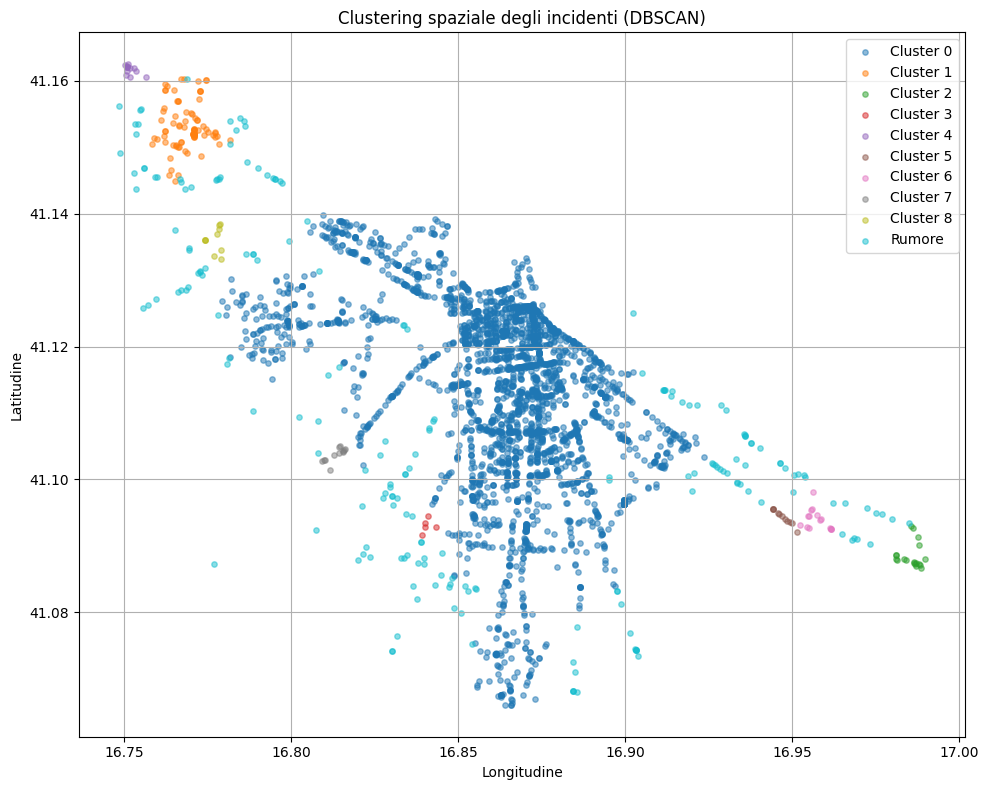

In [44]:
# Coordinate per il clustering
coord = df_geo_pulito[['latitudine', 'longitudine']].values
 
# DBSCAN: eps aumentato per ottenere meno cluster
db = DBSCAN(eps=0.004, min_samples=10).fit(coord)

# Etichette dei cluster
df_geo_pulito['cluster'] = db.labels_

# Visualizzazione
plt.figure(figsize=(10, 8))
unique_labels = set(db.labels_)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    subset = df_geo_pulito[df_geo_pulito['cluster'] == label]
    plt.scatter(subset['longitudine'], subset['latitudine'],
                s=15, alpha=0.5,
                label=f'Cluster {label}' if label != -1 else 'Rumore',
                c=np.array([colors(label % 10)]))

plt.title(f"Clustering spaziale degli incidenti (DBSCAN)")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Profilazione dei cluster

Per ciascun cluster stimato calcoliamo:
- numero di incidenti senza lesioni,
- numero di incidenti con lesioni,
- totale incidenti.

Questa sintesi permette di confrontare i cluster non solo per densità, ma anche per gravità relativa.


In [58]:

df_geo_pulito['cluster_id'] = db.labels_
df['cluster_id'] = df_geo_pulito['cluster_id']
df['cluster_id'] = df['cluster_id'].fillna(-1)

# Calcolo numero di incidenti per cluster e tipo di lesione
cluster_summary = df.groupby(['cluster_id', 'incidente_con_lesioni']).size().unstack(fill_value=0)
cluster_summary.columns = ['incidenti_senza_lesioni', 'incidenti_con_lesioni']
cluster_summary['totale_incidenti'] = cluster_summary.sum(axis=1)

# Calcolo percentuale incidenti con lesioni
cluster_summary['percentuale_lesioni'] = (
    cluster_summary['incidenti_con_lesioni'] / cluster_summary['totale_incidenti']
).round(2)  # arrotondato a 2 decimali

# Visualizza i cluster più pericolosi (ordinati per % lesioni e numero minimo di incidenti)
cluster_summary_sorted = cluster_summary[cluster_summary['totale_incidenti'] >= 10].sort_values(by='percentuale_lesioni', ascending=False)

cluster_summary_sorted.head(10)  # mostra i 10 cluster più critici



,incidenti_senza_lesioni,incidenti_con_lesioni,totale_incidenti,percentuale_lesioni
cluster_id,,,,
2.0,7,12,19,0.63
6.0,7,8,15,0.53
1.0,44,42,86,0.49
4.0,7,6,13,0.46
-1.0,181,140,321,0.44
0.0,1661,1261,2922,0.43
7.0,8,4,12,0.33
5.0,8,3,11,0.27
8.0,8,2,10,0.20


In [63]:
labels = db.labels_

# Calcola il Silhouette Score, escludendo outlier (-1)
mask = labels != -1
if np.unique(labels[mask]).size > 1:
    score = silhouette_score(coord[mask], labels[mask])
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette Score non calcolabile: meno di 2 cluster validi.")

Silhouette Score: 0.096
